# Lab 1 - Random exploration

This section has two goals.

1. To get you familiar with the python library we will be using for most of the semester to simulate and explore exploration.
2. Explore the utility of random exploration as an exploration strategy.


Google Colab is a simple free way to run python code. See the _python_ chapter for more on it. Most of the chapters and assignments in this book have a button to open in Colab (see the rocket button at the top).

## Background

The _explorationlib_ library has three primary parts for running simulations. Here we will outline the three and give a brief explanation for how they work.

### **Agents**

_Agents_ are functions that have a specific set of 1) inputs, 2) computations, and 3) outputs. The input-outut form is defined by the environment (see below). For example, in the bacterial foraging environments the inputs are scent signals reflecting "food" and the ouputs are direction of movement along a 2-dimensional grid. For the bandit environments, the inputs are feedback signals (e.g., rewards) and the outputs are $n$ actions, where $n$ is the number of possible choice options. Agents have an internal _state_ object that is updated according to various algorithms that we will play with in class.


### **Environments**

_Environments_ define the contingencies that agents act on. Here we use the _gym_ library for most of our simulations. There are two classes of environments we will work with: foraging grids and bandits. These will be explained in detail later.

### **Experiment**

The _experiment_ function takes an agent, an environment, and a set of relevant parameters and executes the simulations.

## Section 0 - Setup

Use the button to open this assignment in a colab. Once it is open, if it is open, run all the cells. Read each cell, then run it, that is. This simple test of the colab is also a good but basic introduction to _explorationlib_, which is the basis for all the experiments and assignments you will see.

If there are no errors, celebrate and consider _this_ assignment complete.

_Note:_ I assume that you, reader, are familiar with python programming already. If you are not, see the _Introduction to python_ assignment.

### Install _explorationlib_
Colab comes with many of the libraries we will need. It does not come with _explorationlib_. It's a module we will be using, and was written to support this book. Let's Install it.

In [1]:
!pip install --upgrade git+https://github.com/coaxlab/explorationlib
!pip install --upgrade git+https://github.com/MattChanTK/gym-maze.git
!pip install celluloid # for the gifs

  Cloning https://github.com/coaxlab/explorationlib to /tmp/pip-req-build-lthg4l8s
  Running command git clone --filter=blob:none --quiet https://github.com/coaxlab/explorationlib /tmp/pip-req-build-lthg4l8s
  Resolved https://github.com/coaxlab/explorationlib to commit 1370823ba06ddf3a3b14929e3de0cb4d16b7ce49
  Preparing metadata (setup.py) ... done
  Created wheel for explorationlib: filename=explorationlib-0.0.1-py3-none-any.whl size=42722 sha256=6a702c4dc33b2b72991fd2c23679b3b943018832aa5ea6337f93cff6a2a1f2d0
  Stored in directory: /tmp/pip-ephem-wheel-cache-tt0qeeys/wheels/71/57/e8/88c93e85ce02efaef024038b2ddcb6c6dec8a1a212f712bb05
Successfully built explorationlib
  Cloning https://github.com/MattChanTK/gym-maze.git to /tmp/pip-req-build-vs0qi0dl
  Running command git clone --filter=blob:none --quiet https://github.com/MattChanTK/gym-maze.git /tmp/pip-req-build-vs0qi0dl
  Resolved https://github.com/MattChanTK/gym-maze.git to commit 83176811b49b5538a6213520612f44fb1bc49114
  Prep

### Import some modules
Let us begin by importing some modules from the standard library. These are just some general purpose tools we will use.

In [2]:
import shutil # For working with files
import glob # To help search for pathnames
import os # For working with the local operating system
import copy # We will be using deep copy a lot
import sys # For flexibility working with different OSs

Next we can import modules that are common to scientific programming in python.

In [3]:
import numpy as np # General purpose utility for math operations
import pandas as pd # For working with data frames
import seaborn as sns # A great plotting utility
import matplotlib.pyplot as plt # Another good plotting utility

Now let's grab a bunch of functions from _explorationlib_ to play with. If our install using _pip_ above worked out, this next cell should run without error.

In [4]:
# All the explorers we will play with are called
# "agents"; a bit of computer science jargon
from explorationlib import agent

# The environments we will simulate live in a "gym"
from explorationlib import local_gym as gym

# Computational experiments are run with 'experiment'
from explorationlib.run import experiment

# Here are some tools to select, save, and load
# data from computational experiments
from explorationlib.util import select_exp
from explorationlib.util import load
from explorationlib.util import save

# A bunch of tools for plotting and for
# movie making
from explorationlib.plot import plot_position2d
from explorationlib.plot import plot_length_hist
from explorationlib.plot import plot_length
from explorationlib.plot import plot_angle_hist
from explorationlib.plot import plot_targets2d
#from explorationlib.plot import render_2d
from explorationlib.plot import show_gif

# A couple metrics for scoring how well, or poorly,
# an exploration experiment went.
from explorationlib.score import search_efficiency
from explorationlib.score import total_reward
#from explorationlib.score import average_reward

Before we go too far, let's do some work to make the plots look nicer.  We don't _have_ to do this, but having clear data visualization helps us better understand our results.

In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.size"] = "16"

Finally, let's set up some better autocomplete and development tools in our notebooks. Again, optional. If this errors out, you might consider skipping it.

In [6]:
# config IPCompleter.greedy=True
# load_ext autoreload
# autoreload 2

### Make a space for the data
Make a folder called "data" to keep experimental data in. We will use it for all our examples.

**WARNING** When running in a colab, anything you save to "data/" will be lost as soon as you shutdown the colab. This is ok for now. We will cover ways to save your data permanently later on.

In [8]:
if not os.path.exists("data"):
    os.makedirs("data")

## Section 1 - Welcome to our virtual world

We are now ready to make a little virtual world and little creatures in it that we can use as our test subjects.

For today we will work just with random search strategies. In particular, we want to show how random movements in a simple foraging context is an effective, if not ideal, strategy for simple organisms.

### Environment

The context that our agent will explore in is a 2-dimensional flat world environment. The environment is enclosed by walls on all sides, preventing our agent from escaping.

Throughout the space there are food sources sprinkled evenly and randomly throughout. Specifically we will distribute the food according to a uniform distribution, which means that every point in space within our environment has an equal likelihood of having a food pellet present. Every time the agent hits a food target they get 1 point.

The _goal_ of the agent is to find at least one food source within the time alloted. More is obviously better, but all our agent needs is one little bite to survive.

### Agents

For most of this class we will be working with artifical agents that I call _valentinos_. Each valentino is a simulated agent that forages the little 2-dimensional virtual world. We have complete control over the valentino's behavior and will expand their capabilities as the class progresses.

We will start simple today with an agent that uses Brownian motion to explore and find food. It is the simplest valentino possible. It doesn't use sensory signals or other environmental information to move about. It just randomly diffuses throughout the environment. We'll name this valentino _Rando_. Rando makes two decisions at every moment (i.e., time point). First, there is the decision of how far to move. We call this the _step size_ and will use the parameter $l_i$ to refer to the length of the step taken at the $i^{th}$ moment. This will be sampled according to an gamma distribution with a scale parameter $\theta$ (with $\theta=2$ for now) and shape parameter $k$ ($k=2$ for now).

This gives us a probability distribution described like this:

$$p(x) = x^{k-1} \frac{e^{\frac{-x}{\theta}}}{\theta^k \Gamma(k)}$$

Here $\Gamma$ is what is known as the gamma function. But we can skip the details for now. Just don't mix it up with the gamma distribution itself (which is described by the above equation that *includes* a gamma function).

So we say that each step $l_i$ is sampled as:

$$l_i \sim Gamma(k,\theta)$$

Let's see what this looks like.

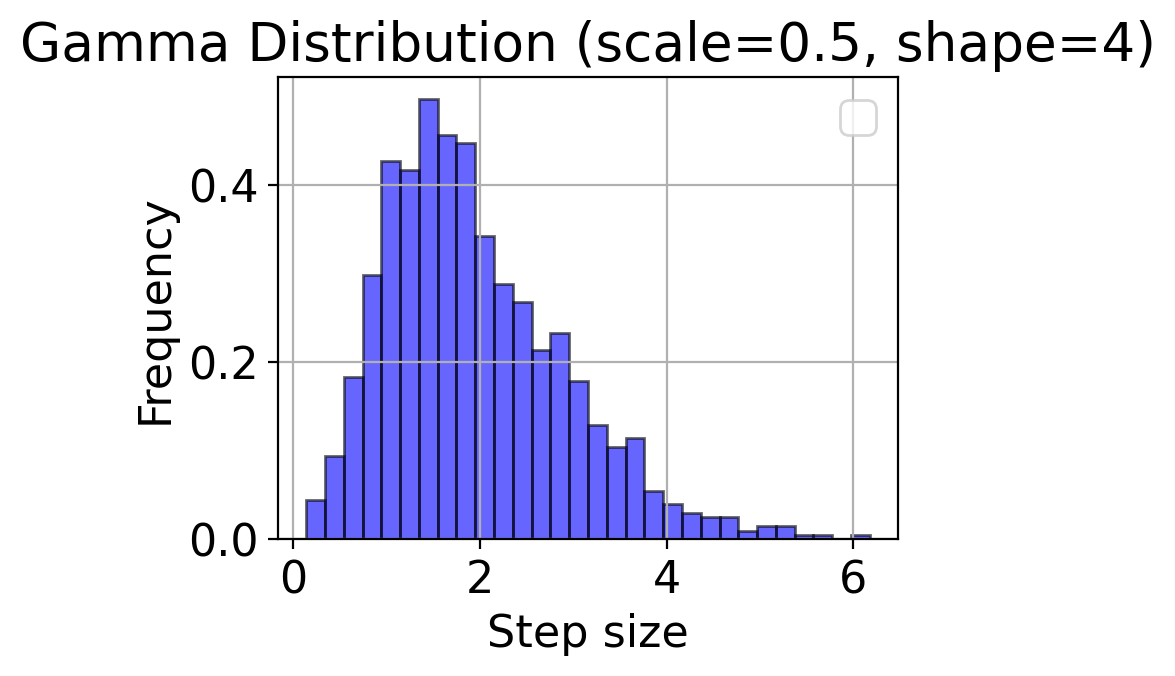

In [9]:
# Set the scale parameter
scale_param = 0.5
shape_param = 4

# Generate gamma distribution data
data = np.random.gamma(scale=scale_param, shape=shape_param, size=1000)


# Create the plot
plt.figure(figsize=(4, 3))
plt.hist(data, bins=30, density=True, alpha=0.6, color='b', edgecolor='black')


# Add titles and labels
plt.title(f'Gamma Distribution (scale={scale_param}, shape={shape_param})')
plt.xlabel('Step size')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()



Along with step length, the agent also must decide the direction of movement. We will use the parameter $\theta$ to represent the angle of movement in polar coordinates. At each moment $i$ the movement direction $\theta_i$ will be sampled according to a uniform distribution ranging from 0 to $2\pi$.

$$\theta_i \sim U(0, 2\pi)$$

This means that at any given moment, Rando can turn in any direction in a $360^{\circ}$ circle. We can visualie this distribution of angles pretty easily.

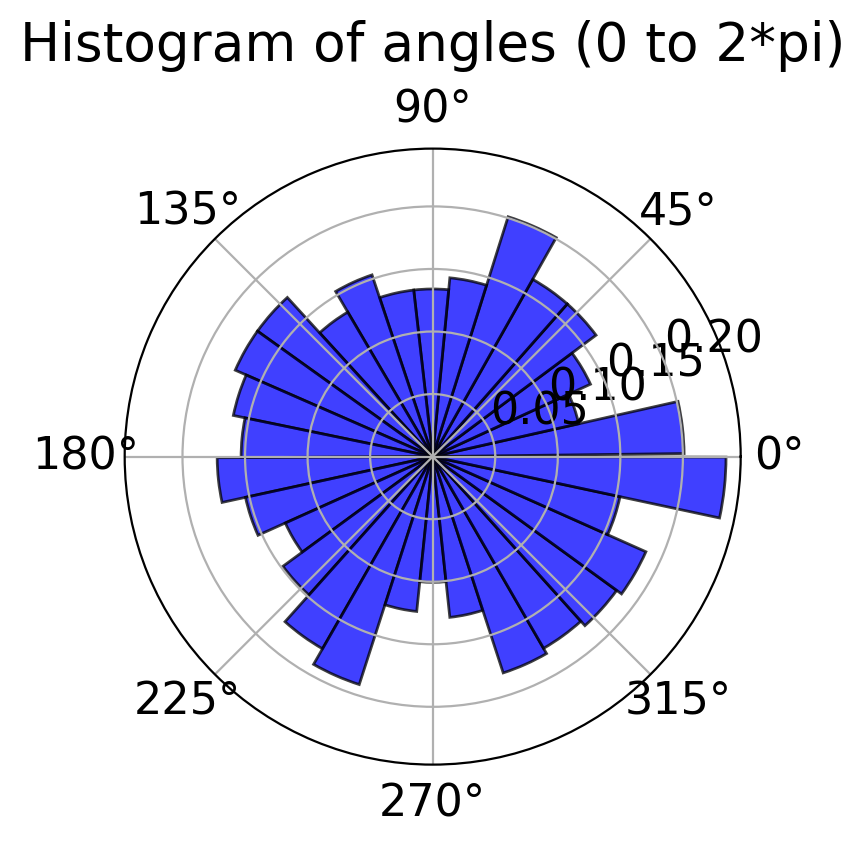

In [10]:
n_points=1000
n_bins=30

# Generate uniform distribution of angles from 0 to 2*pi
angles = np.random.uniform(0, 2*np.pi, n_points)

# Create the polar histogram
plt.figure(figsize=(4, 4))
ax = plt.subplot(111, projection='polar')

# Plot the histogram
ax.hist(angles, bins=n_bins, density=True, color='b', alpha=0.75, edgecolor='black')

# Add titles and labels
plt.title('Histogram of angles (0 to 2*pi)', va='bottom')
plt.grid(True)

# Show the plot
plt.show()


### Task

We want to run a simple experiment using _explorationlib_. We will simulate Rando's behavior as they wander the environment seeking "food" resources that are detectable by scents (though our toy animal has no sensory abilities yet).

1. Instantiate a single Rando agent, in our 2-d foraging environment.
2. Run an experiment, for 500 steps.
3. Plot the environment and the agent's path in it.
4. Score the agent, and reward (targets), and its efficiency.

#### Instantiate

We can get things started by specifying all of the relevant parameters and objects.

In [139]:
# Parameters
exp_name = "data/explorationlib_rando.pkl"   # where we can store the data
num_experiments = 1             # we only want to run one experiment
num_steps = 500                 # how many exploration steps in space?

scale = 0.5           # Diffusion constant
shape = 4             # Length of the skew (lower = more skew)
boundary = (10, 10)   # a 2d world, 10 by 10
mode = "stopping"     # stop when we hit a wall
num_targets = 100     # how many targets in the arena?

# Setup targets. Targets are an abstraction for the
# thing we are exploring to find. For now, all targets
# are just the number 1 placed randomly about.
targets = gym.uniform_targets(num_targets, boundary)
values = gym.constant_values(targets, 1)

# Setup agent and env
env = gym.Bounded(boundary=boundary, mode=mode)
env.add_targets(targets, values)
rando = agent.Diffusion2d(scale=scale, shape=shape)

#### Run

We use the _experiment_ function to execute the simulations.

(If you've been playing with this notebook for a while, then clear the old output first.)

In [140]:
# Cleanup old versions
for path in glob.glob(f"{exp_name}"):
    os.remove(path)

In [141]:
# Run!
exp_data = experiment(
    f"Rando",
    rando,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    seed=5858,
    dump=False,
)

Rando:   0%|          | 0/1 [00:00<?, ?it/s]

#### Plot

_explorationlib_ has a set of built in visualization functions that we loaded at the beginning. We'll use a few here to see how our agents are doing.

First let's now see our environment. The plot below will show the foraging space for Rando and each dot indicates the location of a food source. Notice the uniform scattering of food across the environment.

<Axes: title={'center': 'Foraging Env.'}, xlabel='x', ylabel='y'>

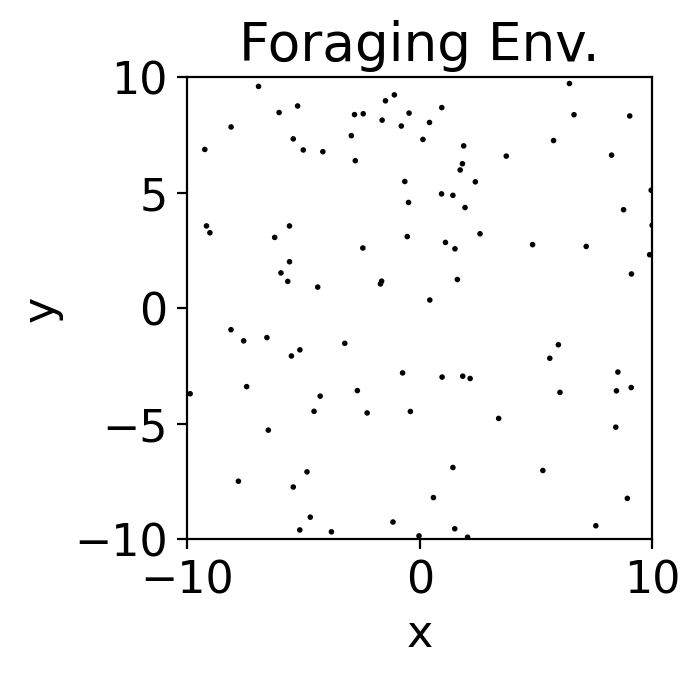

In [142]:
# Plot the 2d env, and the targets (black dots)
plot_targets2d(env, boundary=boundary, title="Foraging Env.", figsize=(3,3))

Now let's take a look at Rando's behavior. We can do this by plotting the positions that the agent (red line) took during this one example run.

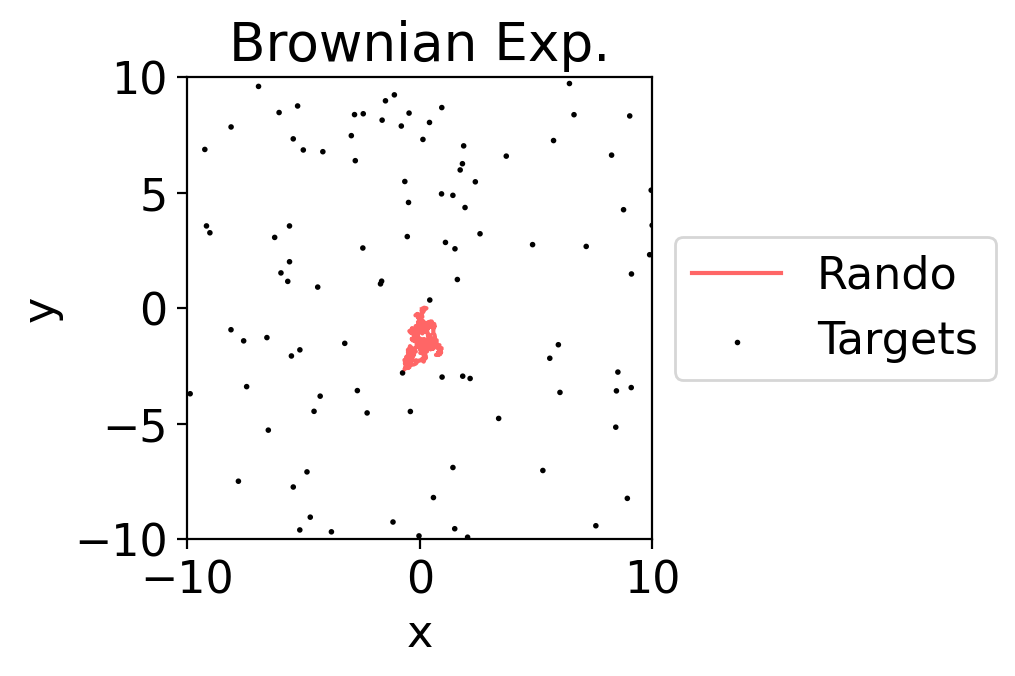

In [143]:
# View size
plot_boundary = (20, 20)

# Agent
ax = None
ax = plot_position2d(
    select_exp(exp_data,0),
    boundary=plot_boundary,
    label=f"Rando",
    title=f"Brownian Exp.",
    color="red",
    alpha=0.6,
    ax=None,
)

ax = plot_targets2d(
    env,
    boundary=boundary,
    color="black",
    alpha=1,
    label="Targets",
    ax=ax,
)

Notice that there are quite a few parameters you can play with to change the size of the plot, colors, and so on. See `explorationlib.plot` for all the options


Finally, let's see how our distribution of step lengths looks. Here we will just plot the step at each jump (or turn) and the histogram of step lengths.

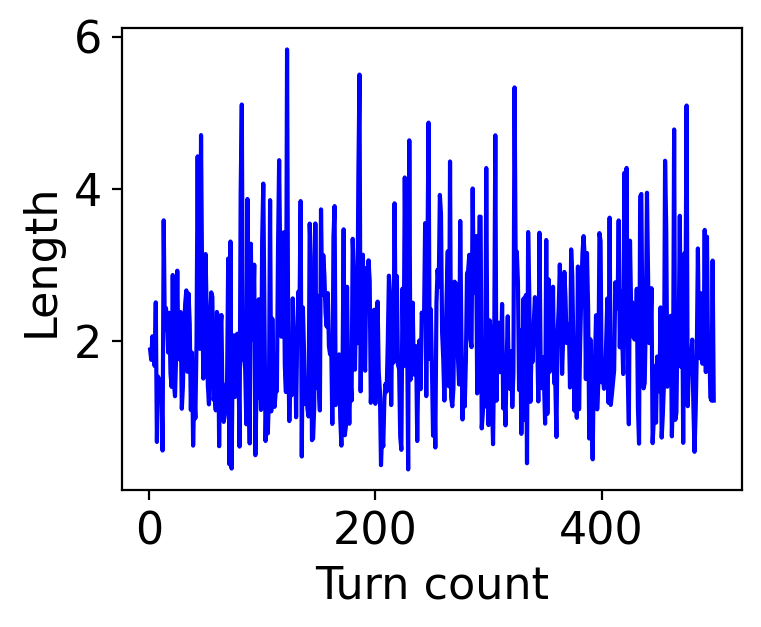

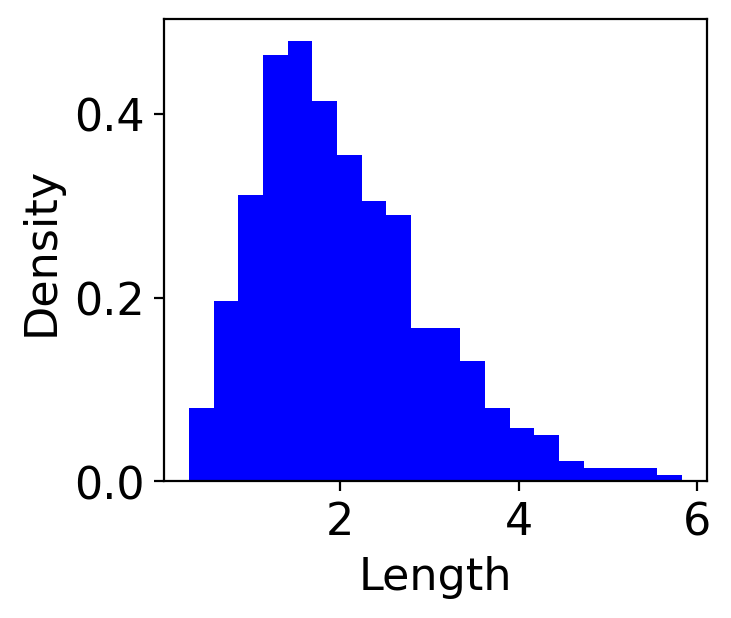

In [144]:
# View size
plot_boundary = (20, 20)

# Agent
ax=None
ax=plot_length(select_exp(exp_data,0),color='blue',figsize=(4,3))
ax=plot_length_hist(select_exp(exp_data,0),color='blue', loglog=False, figsize=(3.5,3))

This distribution should look very similar to the sampling distribution we used to make it (i.e., the gamma distribution above)

#### Score

Now we can quantify Rando's behavior in this simple experiment.

First we will look at _total_reward_, which counts how many times Rando ran into a food target. Recall that every time the agent hits a food source, they get 1 point.

In [145]:
# Total rewards (targets) collected
total_reward(exp_data)

total_reward:   0%|          | 0/1 [00:00<?, ?it/s]

[2.0]

So our agent hit their food this many times.

Next we will look at the efficiency of the search, which is just the number of movements taken by the agent over the number of food targets collected.

In [146]:
# How efficient (movements/target) was the search
search_efficiency(exp_data)

search_efficiency:   0%|          | 0/1 [00:00<?, ?it/s]

[0.04008016032064093]

This means that our Rando agent took around 5 steps to hit a new food source.

We want this score to be as low as possible. Right now this number doesn't mean much because we have nothing to compare Rando's behavior to. We will come back to it in later labs.

#### Play

Go back to the top of this section, change the _random seed number_ in the cell where we ran the experiment and run it again. Each time you do you should generate a new exploration pattern. You'll get different rewards and efficiency each time as well.


---
### Question 1.1

Rerun the simulation above but now have the agent run for 10,000 steps. What happens to the histogram (or distribution) of step lengths?

__Answer:__

The distribution becomes steeper and more bunched up/more density on the left.

---
### Question 1.2

Repeat the experiment 10 times with different random seeds. Keep track of the two outcome measures, _total reward_ and _search efficiency_. How much variation do you see from run to run?

__Answer:__

For the most part, I would say there is not that much variation except for a couple of seeds. The total reward ranged from 3-7 with mostly 5s.

---
### Question 1.3

Now set the random seed number back to 5858 and rerun the original simulation. Then change the number of steps in each simulation (the _num_steps_ parameter) to 1000. Change the scale parameter to 2 and keep the shape parameter at 4. How do the two outcome measures (_total reward_ and _search efficiency_) change? How does the distribution of step lengths change.

__Answer:__

The total reward was smaller but had higher search efficiency. The distribution of step lengths was broadder with longer lengths.


---
**IMPORTANT** Did you collaborate with anyone on this assignment, or use LLMs like ChatGPT? If so, list their names here.
> *Write Name(s) here*